# Install the required packages

In [ ]:
# Install google cloud vision
!pip install google-cloud
!pip install google-cloud-vision

# Set up Google Cloud Project

### Step 1: Create a Google Cloud Project
Go to the [Google Cloud Console](https://console.cloud.google.com/projectcreate) and create a new project.
### Step 2: Enable Cloud Vision API
Go to the [Google Vision Wizard Page](https://console.cloud.google.com/apis/credentials/wizard?api=vision.googleapis.com), create a new service account to allow us to access the Cloud Vision API.
### Step 3: Create credential JSON key
After creating the service account, click on the service account and go to the `Keys` tab. Click on `Add Key` and `Create new key`.
### Step 4: Download JSON key
The key should be automatically downloaded. This file should be named like `<project_id>-<hash>.json` for example `my-project-1234567890abcdef.json`.

# Define interface for Google Cloud Vision API

Create an GoogleVision class to send image to Google Cloud Vision API

In [6]:
from google.cloud.vision import ImageAnnotatorClient, Image, EntityAnnotation
import PIL.Image as PILImage
from PIL import ImageDraw, ImageFont
from io import BytesIO

FONT = ImageFont.truetype("assets/THSarabun.ttf", 20)

class GoogleVision:
    """
    Google Vision API client
    
    This class allows you to recognize text in an image using Google Vision API.
    """
    def __init__(self, credential_path: str) -> None:
        """Create a Google Vision API client using the given credential path"""
        self.client: ImageAnnotatorClient = ImageAnnotatorClient.from_service_account_json(credential_path)

    def recognize(self, image: PILImage.Image) -> list[EntityAnnotation]:
        """Detect bounding box and recognize text in an image from the given PIL image"""
        # Convert PIL image to binary
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        image_binary = buffered.getvalue()
        # Construct image object
        image = Image(content=image_binary)
        # Send request to Google Vision API
        response = self.client.text_detection(image)
        # Handle error.
        if response.error.message:
            raise Exception(
                f"{response.error.message}\nFor more info on error messages, check: https://cloud.google.com/apis/design/errors"
            )
        # Get all annotations except the first one (all parsed text)
        annotations = [annotation for idx, annotation in enumerate(response.text_annotations) if idx != 0]
        return annotations
    
    @staticmethod
    def draw_bbox(image: PILImage.Image, annotations: list[EntityAnnotation], label_offset: int = 20) -> None:
        """Draw bounding box and text on the given image"""
        draw = ImageDraw.Draw(image)
        for annotation in annotations:
            # Get information in the annotation
            text = annotation.description
            vertices = [(vertex.x, vertex.y) for vertex in annotation.bounding_poly.vertices]
            # Draw bounding box
            draw.polygon(vertices, outline='blue')
            # Draw text
            draw.text((vertices[0][0], vertices[0][1] - label_offset), text, fill='red', font=FONT)
        return image

In [3]:
# Create an instance of GoogleVision
PATH_TO_CREDENTIAL_JSON = "put/your/credential/here.json"
api = GoogleVision(PATH_TO_CREDENTIAL_JSON)

I0000 00:00:1725072388.169887 3227951 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


# Load the data
We load the receipt to run text detection and recognition on it.

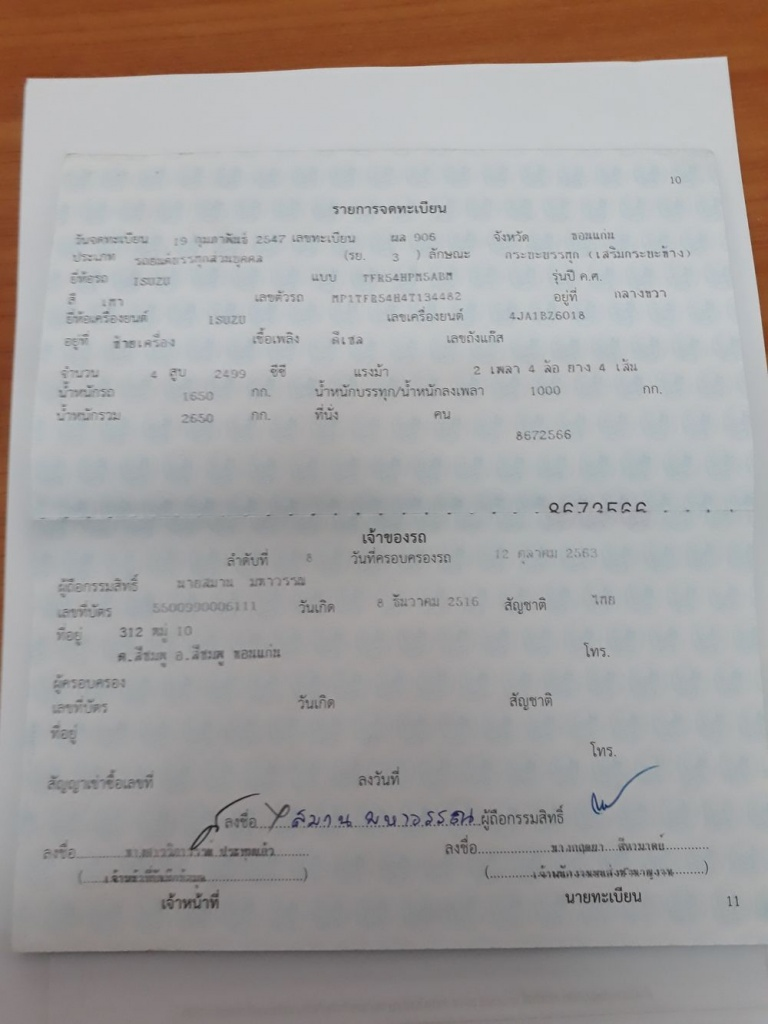

In [4]:
from PIL import Image

path = "path/to/image.jpg"
image = Image.open(path).convert("RGB")
display(image)

Send the receipt to the Google Cloud Vision API to extract the text from the image.

In [7]:
annotations = api.recognize(image)

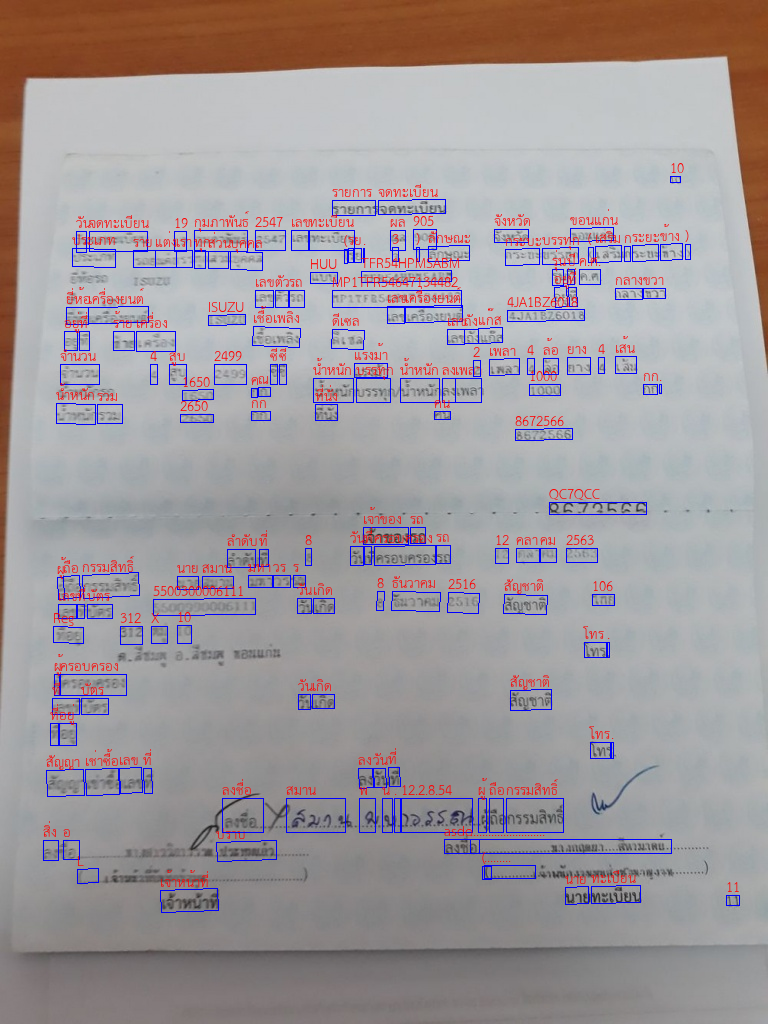

In [8]:
drawn_image = GoogleVision.draw_bbox(image, annotations)
display(drawn_image)